# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [1]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
!kaggle datasets download -d khaledzsa/traffic-dataset
!unzip traffic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/traffic-dataset
License(s): unknown
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 67.2MB/s]
Archive:  traffic-dataset.zip
  inflating: Traffic Data.csv        


In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
# from statsmodels.tsa.arima_model  import

In [162]:
df = pd.read_csv('/content/Traffic Data.csv')
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00
...,...,...,...,...,...,...,...,...
19995,2723.0,296.42,0.0,0.0,40,Clouds,scattered clouds,2018-06-06 21:00:00
19996,5895.0,285.58,0.0,0.0,40,Clouds,scattered clouds,2017-10-25 15:00:00
19997,1132.0,275.30,0.0,0.0,1,Clear,sky is clear,2018-03-28 23:00:00
19998,5525.0,260.94,0.0,0.0,75,Clouds,broken clouds,2018-02-12 15:00:00


In [163]:
# Make sure the datetime column is correctly parsed.
df['date_time'] = pd.to_datetime(df['date_time'])

df.dtypes

,0
traffic_volume,float64
temp,float64
rain_1h,float64
snow_1h,float64
clouds_all,int64
weather_main,object
weather_description,object
date_time,datetime64[ns]


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [164]:
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,date_time
count,19980.000000,20000.000000,20000.000000,20000.0,20000.000000,20000
mean,3278.186887,281.162680,0.048396,0.0,49.384600,2017-10-22 04:13:17.939999744
min,113.000000,243.390000,0.000000,0.0,0.000000,2016-11-18 15:00:00
25%,1228.750000,271.950000,0.000000,0.0,1.000000,2017-04-30 14:45:00
50%,3430.000000,281.825000,0.000000,0.0,75.000000,2017-10-21 07:30:00
75%,4928.000000,291.840000,0.000000,0.0,90.000000,2018-04-13 21:00:00
max,16781.000000,310.070000,10.600000,0.0,92.000000,2018-09-30 23:00:00
std,1977.171357,12.661288,0.398007,0.0,39.647341,NaN


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       19980 non-null  float64       
 1   temp                 20000 non-null  float64       
 2   rain_1h              20000 non-null  float64       
 3   snow_1h              20000 non-null  float64       
 4   clouds_all           20000 non-null  int64         
 5   weather_main         20000 non-null  object        
 6   weather_description  20000 non-null  object        
 7   date_time            20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


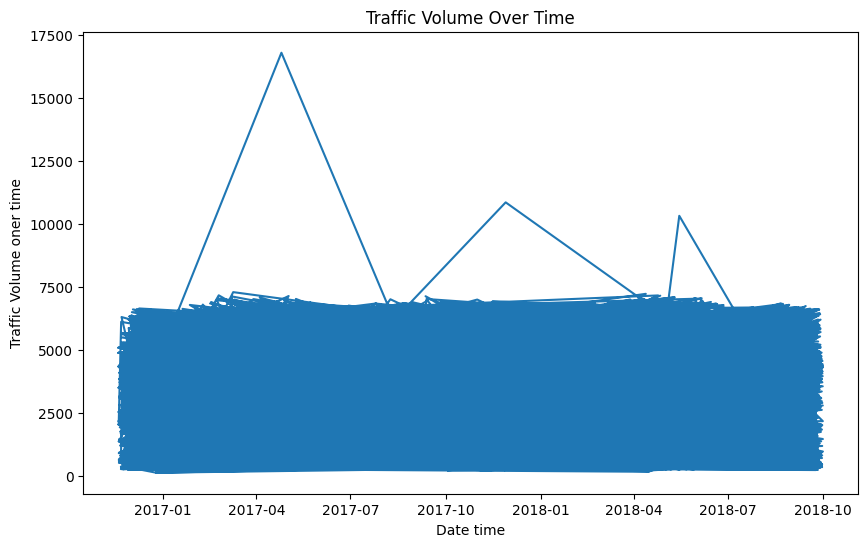

In [166]:
# Plot the time series data.
plt.figure(figsize=(10, 6))
plt.plot(df['date_time'], df['traffic_volume'])
plt.title('Traffic Volume Over Time')
plt.xlabel('Date time')
plt.ylabel('Traffic Volume oner time')
plt.show()


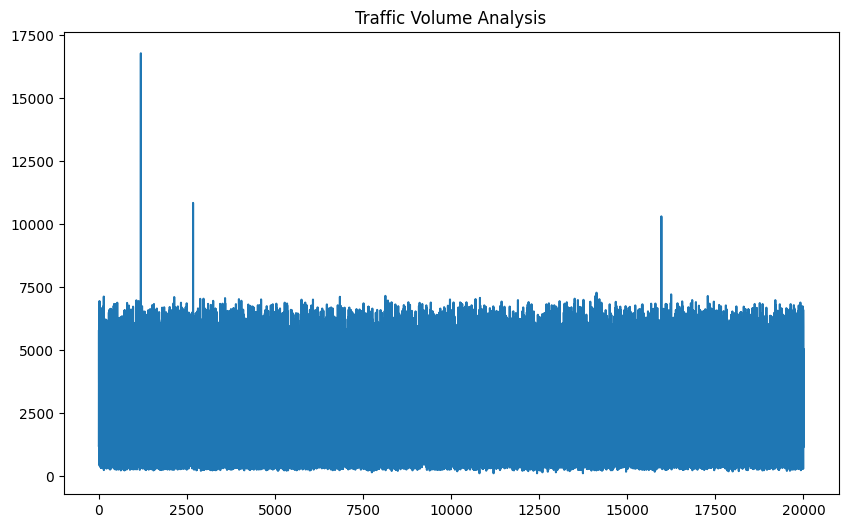

In [80]:
# Analyze trends, seasonality, and potential outliers.
plt.figure(figsize=(10, 6))
df['traffic_volume'].plot()
plt.title('Traffic Volume Analysis')
plt.show()


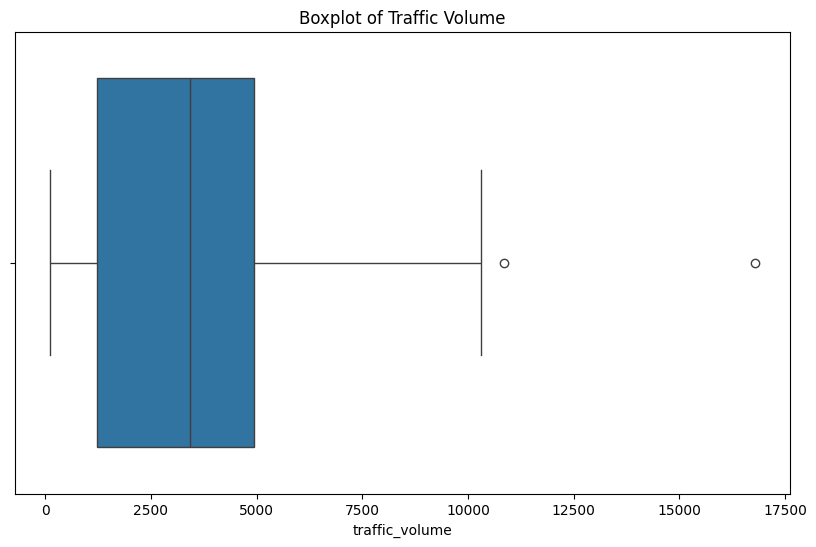

In [81]:
# Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
plt.figure(figsize=(10, 6))
sns.boxplot(x='traffic_volume', data=df)
plt.title('Boxplot of Traffic Volume')
plt.show()


* there is outlier

In [158]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df):
    df_no_outliers = df.copy()
    for col in df.select_dtypes(include=np.number).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove outliers
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

    return df_no_outliers


df_no_outliers_iqr = remove_outliers_iqr(df)
print(f"Number of rows before removing outliers: {len(df)}")
print(f"Number of rows after removing outliers: {len(df_no_outliers_iqr)}")

Number of rows before removing outliers: 19999
Number of rows after removing outliers: 17830


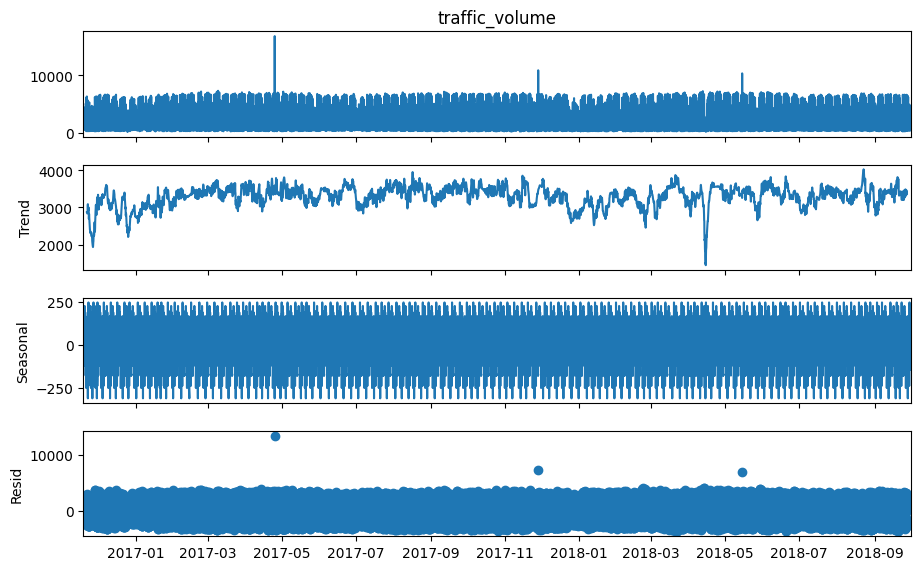

In [159]:
# Seasonal Decomposition
decomposition = seasonal_decompose(df['traffic_volume'].dropna(), model='additive', period=24*7)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(10, 6)
plt.show()


## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [84]:
df.isnull().sum()

,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [85]:
# Handle any missing values in the dataset.
# Fill missing values using forward fill(ffill) , because its time series data

df['traffic_volume'] = df['traffic_volume'].fillna(method='ffill')

In [86]:
df.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [ ]:
# If necessary, resample the data to ensure consistent time intervals.

In [ ]:
# Create any additional features needed, such as lags or moving averages.

In [87]:
# Make sure that the dates are sorted correctly.
# Time Period: Starting from 18-11-2016
df = df.sort_values('date_time')
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
7745,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,2016-11-18 15:00:00
4628,4872.0,274.08,0.0,0.0,90,Fog,fog,2016-11-18 15:00:00
14496,4872.0,274.08,0.0,0.0,90,Mist,mist,2016-11-18 15:00:00
8867,5074.0,273.84,0.0,0.0,90,Fog,fog,2016-11-18 16:00:00
3867,5074.0,273.84,0.0,0.0,90,Mist,mist,2016-11-18 16:00:00
...,...,...,...,...,...,...,...,...
6605,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00
14241,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00
9500,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00
15201,1450.0,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [88]:
# Shift Method :
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)

In [89]:
# Difference between traffic_volume:
df['traffic_volume_diff'] = df['traffic_volume'].diff()

In [90]:
df.set_index('date_time', inplace=True)

In [91]:
# Date Features : Day of the week, Month, Day of the year
df['Day_of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Day_of_Year'] = df.index.dayofyear


In [92]:
# Drop any rows with NaN after feature engineering
df.dropna(inplace=True)

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [46]:
# # Ensure the split maintains the time order of the data.
# split_date = '2016-11-18'
# train = df[:split_date]
# test = df[split_date:]

# print(f"Trainind set : {train.shape}")
# print(f"testing set : {test.shape}")


Trainind set : (19, 12)
testing set : (19999, 12)


In [93]:
# Define the split point
split_date = '2018-01-01'
train = df[:split_date]
test = df[split_date:]

print(f"Training data: {train.shape}")
print(f"Testing data: {test.shape}")


Training data: (12074, 12)
Testing data: (7949, 12)


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [94]:
df.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'prev_traffic_volume',
       'traffic_volume_diff', 'Day_of_Week', 'Month', 'Day_of_Year'],
      dtype='object')

In [95]:
# feature & target
feature =['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'prev_traffic_volume', 'traffic_volume_diff', 'Day_of_Week', 'Month', 'Day_of_Year']
target = ['traffic_volume']

X_train = train[feature]
y_train = train[target]
X_test = test[feature]
y_test = test[target]

In [96]:
# Use a scaling method such as MinMaxScaler or StandardScaler.
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

In [97]:
# Ensure scaling is applied correctly to both training and testing data.

train_scaled

array([[-0.50054817,  0.        ,  0.        , ...,  0.51012423,
         1.07041604,  1.09171318],
       [-0.50054817,  0.        ,  0.        , ...,  0.51012423,
         1.07041604,  1.09171318],
       [-0.5208702 ,  0.        ,  0.        , ...,  0.51012423,
         1.07041604,  1.09171318],
       ...,
       [-2.39388386,  0.        ,  0.        , ..., -1.47241055,
        -1.65701469, -1.77319312],
       [-2.40997214,  0.        ,  0.        , ..., -1.47241055,
        -1.65701469, -1.77319312],
       [-2.45484995,  0.        ,  0.        , ..., -1.47241055,
        -1.65701469, -1.77319312]])

In [98]:
test_scaled

array([[-2.59371715,  0.        ,  0.        , ..., -1.47241055,
        -1.65701469, -1.77319312],
       [-2.61742618,  0.        ,  0.        , ..., -1.47241055,
        -1.65701469, -1.77319312],
       [-2.63605471,  0.        ,  0.        , ..., -1.47241055,
        -1.65701469, -1.77319312],
       ...,
       [ 0.23189163,  0.        ,  0.        , ...,  1.50139161,
         0.52492989,  0.64685195],
       [ 0.17769955,  0.        ,  0.        , ...,  1.50139161,
         0.52492989,  0.64685195],
       [ 0.1802398 ,  0.        ,  0.        , ...,  1.50139161,
         0.52492989,  0.64685195]])

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [ ]:
# ARIMA
# GRU

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [99]:
! pip install --upgrade statsmodels

In [102]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.7 MB/s eta 0:00:00


In [105]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
model_arima = ARIMA(train[target], order=(5, 1, 0))
model_arima_fit = model_arima.fit()


In [104]:
# # Fit ARIMA Model
# model_arima = auto_arima(train[target], order=(5,1,0))
# model_arima_fit = model_arima.fit(disp=0)

TypeError: ARIMA.fit() missing 1 required positional argument: 'y'

In [167]:
 model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                12074
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -96291.644
Date:                Sun, 25 Aug 2024   AIC                         192595.288
Time:                        08:25:48   BIC                         192639.680
Sample:                             0   HQIC                        192610.175
                              - 12074                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4172      0.003    138.317      0.000       0.411       0.423
ar.L2          0.0201      0.005      3.903      0.000       0.010       0.030
ar.L3         -0.1015      0.009    -11.198      0.000      -0.119      -0.084
ar.L4          0.0065      0.010      0.634      0.526      -0.014       0.027
ar.L5         -0.0126      0.011     -1.140      0.254      -0.034       0.009
sigma2      4.958e+05   2065.733    240.009      0.000    4.92e+05       5e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            585165.68
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [152]:
predictions_arima = model_arima_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
predictions_arima

,predicted_mean
12074,687.675638
12075,659.961185
12076,684.508639
12077,710.477463
12078,728.537689
...,...
20018,733.023537
20019,733.023537
20020,733.023537
20021,733.023537


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [113]:
mse_arima = mean_squared_error(test[target], predictions_arima)
mae_arima = mean_absolute_error(test[target], predictions_arima)


In [114]:
print(f'MSE : {mse_arima}')
print(f'MAE : {mae_arima}')

MSE : 10296936.759778267
MAE : 2632.528420478219


In [115]:
rmse_gru = np.sqrt(mae_gru)
mape_gru = mean_absolute_percentage_error(y_test, predictions_arima)

print(f'RMSE : {rmse_gru}')
print(f'MAPE: {mape_gru}')


RMSE : 51.308171088806304
MAPE: 0.7588423526871878


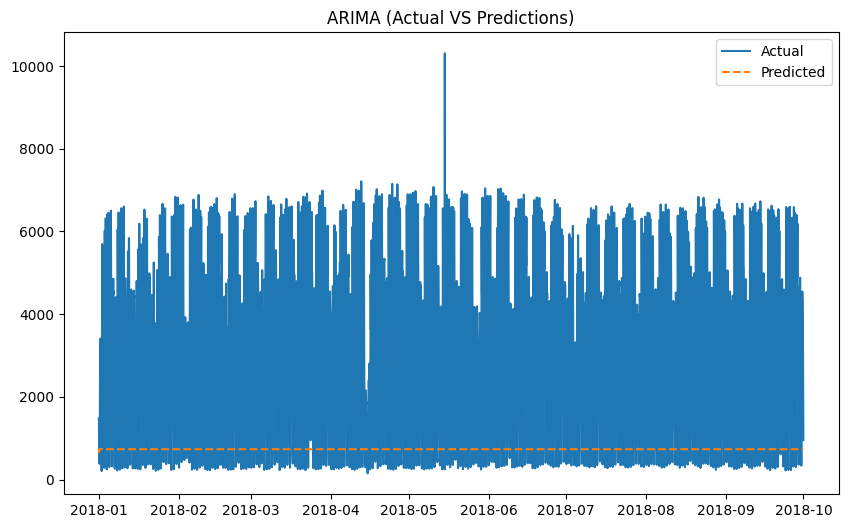

In [116]:
# Plot the predicted vs actual values for the test set.
plt.figure(figsize=(10, 6))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, predictions_arima, label='Predicted', linestyle='--')
plt.legend()
plt.title('ARIMA (Actual VS Predictions)')
plt.show()


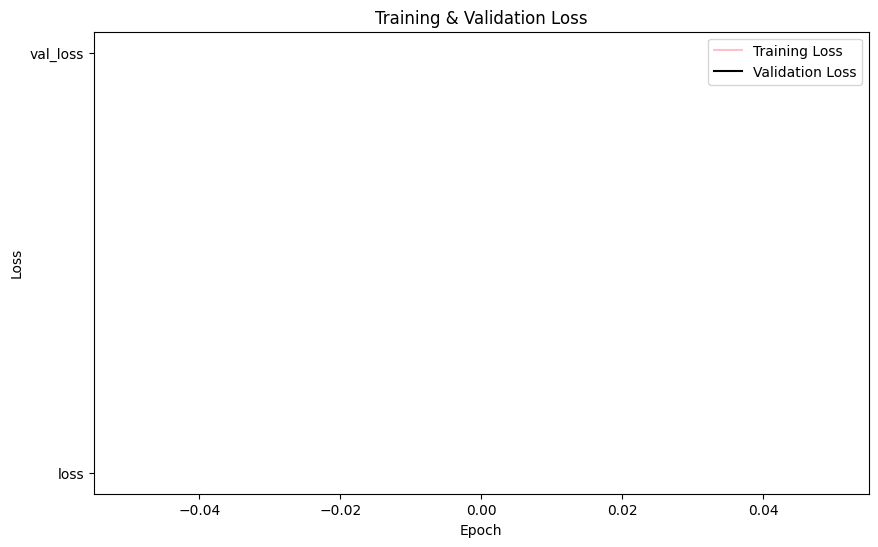

In [173]:
# Plot the loss and the validation loss.
plt.figure(figsize=(10, 6))
plt.plot(['loss'], label='Training Loss', color='Pink')
plt.plot(['val_loss'], label='Validation Loss', color='Black')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


* here the plot dosnt give me a resault so , compare between model from the 'mse_arima', 'mae_arima', 'rmse_gru', 'mape_gru' .

* MSE : 10296936.759778267

  MAE : 2632.528420478219

  RMSE : 51.308171088806304

  MAPE: 0.7588423526871878

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [134]:
# reshape data for GRU Just to prepare the data for GRu model
train_scaled = train_scaled.reshape((train_scaled.shape[0], 1, train_scaled.shape[2]))
test_scaled = test_scaled.reshape((test_scaled.shape[0], 1, test_scaled.shape[2]))


In [121]:
# GRU Model
model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(50, activation='relu', input_shape=(train_scaled.shape[1], train_scaled.shape[2])),
    tf.keras.layers.Dense(1)
])

In [122]:
# Compile the GRU Model
model_gru.compile(optimizer='adam', loss='mean_squared_error')

In [126]:
history_gru = model_gru.fit(train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 160.3689 - val_loss: 341.2640
Epoch 2/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 148.5074 - val_loss: 335.8972
Epoch 3/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 150.9160 - val_loss: 325.8294
Epoch 4/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 128.5065 - val_loss: 291.8710
Epoch 5/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 125.7808 - val_loss: 249.8204
Epoch 6/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 114.3182 - val_loss: 267.7909
Epoch 7/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 109.6510 - val_loss: 206.6995
Epoch 8/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 100.3807 - val_loss: 188.2869
Epoch 9/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 99.7099 - val_loss: 190.6197
Epoch 10/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 91.6015 - val_loss: 171.0354
Epoch 11/100
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 83.4167 - val_loss: 158.4376


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [127]:
# Generate Prediction on test set
prediction_gru = model_gru.predict(test_scaled).flatten()


249/249 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [136]:
prediction_gru_df = pd.DataFrame(list(zip(y_test, prediction_gru)), columns=['Actual', 'Predicted'])
prediction_gru_df.head()

,Actual,Predicted
0,traffic_volume,1480.384766


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [141]:
# Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
mae_gru = mean_absolute_error(y_test, prediction_gru)
rmse_gru = np.sqrt(mae_gru)
mape_gru = mean_absolute_percentage_error(y_test, prediction_gru)

print(f'MAE : {mae_gru}')
print(f'RMSE : {rmse_gru}')
print(f'MAPE: {mape_gru}')

MAE : 2.295697819648231
RMSE : 1.5151560380529232
MAPE: 0.0021300051345334997


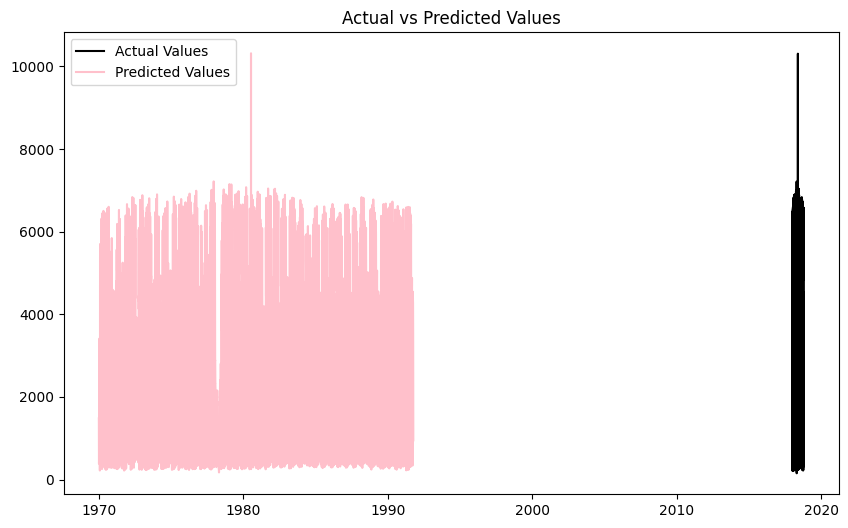

In [169]:
# Plot the predicted vs actual values for the test set.
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values', color='black')
plt.plot(prediction_gru, label='Predicted Values', color='pink')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

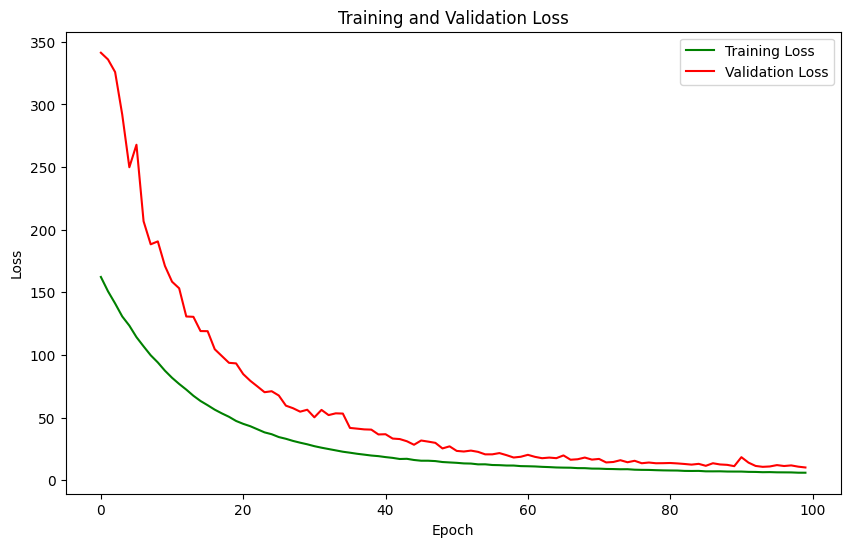

In [174]:
# Plot the loss and the validation loss.
plt.figure(figsize=(10, 6))
plt.plot(history_gru.history['loss'], label='Training Loss', color='green')
plt.plot(history_gru.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Project Questions:

1. **Data Preprocessing**: Explain why you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

* A1 \ am handel with missing value using fillna, because its a seires data and this is the best way for it , and then i make sure the date time was stored using .sort_values() function.

* A2\ am created this new value: prev_traffic_volume to include previous values ​​of traffic_volume , which helps improve prediction because the values ​​in the prediction depend on previous values ​​in the data.

   am also created a new value: traffic_volume_diff to include the difference between the current value and the previous value, which represents changes in traffic_volume over time.



* A3 \ ARIMA Model :
  am choose this order randomly : order=(5, 1, 0) witch is mean
  5 : p=5
  1 : d=1
  0 :  q=0
  and this is the instructions for this model :
  MSE : 10296936.759778267
  MAE : 2632.528420478219
  RMSE : 51.308171088806304
  MAPE: 0.7588423526871878

  this is resault mean the ARIMA model was not the best model for this predection   



* A4\ RGU Model:
  The first thing I do is resampling the data to prepare for the GRU model
  Then I define the GRU model using keras using relu activation function and 50 hidden layers and one output.

  Here is the result in model fitting:
  loss: 5.9180 - val_loss: 10.1037

  Here are the instructions for this model:

  MAE: 2.295697819648231
  RMSE: 1.5151560380529232
  MAPE: 0.0021300051345334997

  After comparing this model to the ARIMA model, I see that the GRU model performed better than ARIMA depends on Training & Validation Loss Plot  

  * i think if using other model like RNN and SARIMA ...., i can find a good prediction and also if am enhance the preivuos model i can get good predictions